In [42]:
import pandas as pd
import numpy as np
from itertools import *
# READ PREPROCESSED DATA FROM R FOR NN
X_df = pd.read_csv("some_X.csv", usecols=['NBR_EMPLOYEES', 'EMPL_GROWTH',
       'COUNTRY_RISK_GROWTH_RATE', 'COUNTRY_RISK_DIVIDEND_YIELD',
       'COUNTRY_RISK_PAYOUT_RATIO', 'VOLATILITY_30D', 'VOLATILITY_180D',
       'PCT_CHG_1_YEAR', 'PCT_CHG_6_M', 'DIVIDEND_YIELD', 'MARKETCAP',
       'TOTAL_ASSETS', 'TOTAL_LIABILITIES', 'CURRENT_ASSETS', 'EBIT',
       'RETAINED_EARNINGS', 'SALES', 'SALES_GROWTH', 'INTEREST_EXPENSES',
       'WHISTLE_BLOWER_POLICY', 'ETHICS_POLICY', 'BRIBERY_POLICY'])
        #       'PCT_WOMEN_EMPLOYEES, PCT_WOMEN_MGT']

Y_df = pd.read_csv("some_Y.csv", usecols=[1])

import torch
from torch import nn
from torch.autograd import Variable

In [56]:
from random import shuffle
def select_most_likely(mlp, loss_fn, x_row, y_row, random=0):
    candidates = [] # TODO: For every -1 in row in the specific columns, try 0 and 1
    
    bad_values = {'WHISTLE_BLOWER_POLICY': 0,
                            'ETHICS_POLICY': 0,
                            'BRIBERY_POLICY': 0,
                 'PCT_WOMEN_EMPLOYEES':-1,
                  'PCT_WOMEN_MGT':-1}

    possible_values_dict = {'WHISTLE_BLOWER_POLICY':[[1,0], [0,1]],
                            'ETHICS_POLICY':[[1,0], [0,1]],
                            'BRIBERY_POLICY':[[1,0], [0,1]],
                           'PCT_WOMEN_EMPLOYEES':[[0], [0.05], [0.010], [0.020], [0.030], [0.040], [0.050], [0.060], [0.070], [0.080], [0.090],[0.0100]],
                           'PCT_WOMEN_MGT':[[0], [0.05], [0.010], [0.020], [0.030], [0.040], [0.050], [0.060], [0.070], [0.080], [0.090],[0.0100]]}
    
    # Make a dictionary for the candidate values that we will expand later
    candidate_dict = {}
    for k, v in x_row.iteritems():
        candidate_dict[k] = []
        
        if (k in bad_values): # We have to encode for the neural network
            if (v == bad_values[k]):
                for i in possible_values_dict[k]:
                    # Directly encode the bad_value
                    candidate_dict[k].append(i)
            else:
                candidate_dict[k] = [possible_values_dict[k][int(v) - 1]] # HACK: IT'S BECAUSE THEY HAVE VALUES 1 AND 2
        else:
            # Just add the value
            candidate_dict[k].append([v])

    best_candidate = None
    lowest_loss = 100000000000

    # In the dictionary we have the different candidates
    if random==1:
        p = list(product(*candidate_dict.values()))
        shuffle(p)
        candidate=p[0]
        best_candidate = Variable(torch.FloatTensor(np.array(list(chain(*list(candidate)))))).cuda()
    else:
        for candidate in product(*candidate_dict.values()):
            input = Variable(torch.FloatTensor(np.array(list(chain(*list(candidate)))))).cuda()
            # Forward the candidate through the network        
            y_pred = mlp(input)
            loss = loss_fn(y_pred, y_row)
            if loss < lowest_loss:
                best_candidate = input
    return best_candidate
    
def get_E_step(model, loss_fn, X_df, Y_df, random=0):
    """ Return a torch CUDA variable of X"""
    df_list = []        
    for (k, j) in zip(X_df.iterrows(), Y_df.iterrows()):
        (_, x) = k
        (_, y) = j
        df_list.append(select_most_likely(model, loss_fn, x, Variable(torch.FloatTensor(y.values).cuda()), random=random))
    return torch.stack(df_list)


In [57]:
def get_M_step(mlp, loss_fn, X, Y, N_iter):
    learning_rate = 1e-5
    for t in range(N_iter):
        y_pred = model(X)
        loss = loss_fn(y_pred, Y)
        if (t % (N_iter / 2) == 0): print(loss)
        model.zero_grad()
        loss.backward()
        for param in model.parameters():
            param.data -= learning_rate * param.grad.data
    return mlp, loss

def EM_algorithm(X_df, Y_df, N_hidden=10, N_iter=30, N_iter_nn=10000):
    
    X = Variable(torch.FloatTensor(X_df.values)).cuda()
    Y = Variable(torch.FloatTensor(Y_df.values)).cuda() # Always stays the same

    # Make an initial model
    print("Making model")
    model = torch.nn.Sequential(
        torch.nn.Linear(X.shape[1] + 3, N_hidden),
        torch.nn.ReLU(),
        #torch.nn.Sigmoid(),
        torch.nn.Linear(N_hidden, Y.shape[1]),
        torch.nn.Sigmoid() # If it doesn't work, look here
    )

    model = model.cuda()
    loss_fn = torch.nn.MSELoss(size_average=False)
    
    previous_loss = 10000000
    # Init
    for i in range(N_iter):
        # Get the expected data
        print("Doing iteration {} E step: finding most likely data".format(i + 1))
        
        random = 1 if i==0 else 0
        X = get_E_step(model, loss_fn, X_df, Y_df, random=random)
        # TODO: Check if the predicted data is the same still?
        # Train the model for some iterations
        print("Doing iteration {} M step: training neural network".format(i + 1))
        learning_rate = 1e-3
        for t in range(N_iter_nn):
            y_pred = model(X)
            loss = loss_fn(y_pred, Y)
            if (t % (N_iter_nn / 2) == 0): print(loss)
            model.zero_grad()
            loss.backward()
            for param in model.parameters():
                param.data -= learning_rate * param.grad.data

        if (-loss + previous_loss)<0.0001: 
            print("Loss not decreasing: exit")
            break
        previous_loss = loss
    return X, model
    

Making model
Doing iteration 1 E step: finding most likely data
Doing iteration 1 M step: training neural network
Variable containing:
 983.8035
[torch.cuda.FloatTensor of size () (GPU 0)]

Variable containing:
 0.5070
[torch.cuda.FloatTensor of size () (GPU 0)]

Doing iteration 2 E step: finding most likely data
Doing iteration 2 M step: training neural network
Variable containing:
 0.4636
[torch.cuda.FloatTensor of size () (GPU 0)]

Variable containing:
 0.4365
[torch.cuda.FloatTensor of size () (GPU 0)]



In [91]:
def two_columns_to_one(bla):
    if bla.equal(torch.FloatTensor([1,0]).cuda()):
        return 1
    elif bla.equal(torch.FloatTensor([0,1]).cuda()):
        return 2
    else:
        print("ERROR")
        return 0


def pytorch_vars_to_df(X_df, X):
    new_df = X_df.copy()
    # Map categorical variables back
    cat = {'WHISTLE_BLOWER_POLICY','ETHICS_POLICY','BRIBERY_POLICY'}
    new_df['WHISTLE_BLOWER_POLICY'] = pd.Series([two_columns_to_one(x) for x in X_final[:, 19:21].data]) - 1
    new_df['ETHICS_POLICY'] = pd.Series([two_columns_to_one(x) for x in X_final[:, 21:23].data]) - 1
    new_df['BRIBERY_POLICY'] = pd.Series([two_columns_to_one(x) for x in X_final[:, 23:25].data]) - 1

    return new_df


In [92]:

#X_final, mlp = EM_algorithm(X_df, Y_df, N_hidden=20, N_iter=10, N_iter_nn=20000)
last_df = pytorch_vars_to_df(X_df, X_final)

last_df["DEFAULT_PROB"] = Y_df["DEFAULT_PROB"]
last_df.to_csv("EM_data.csv")

In [68]:
outputs = (mlp(X_final).data).cpu()

In [81]:
outputs.numpy()
Y_df.values

array([[0.02813887],
       [0.02176614],
       [0.03820742],
       ...,
       [0.0071764 ],
       [0.01487532],
       [0.00735415]])

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

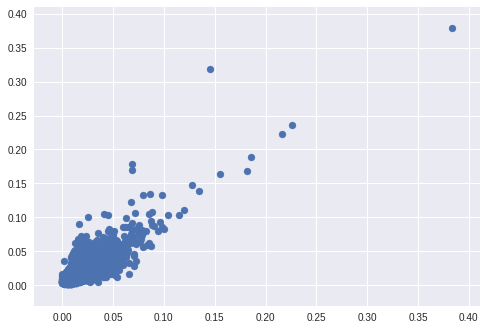

In [86]:
plt.scatter(outputs.numpy(), Y_df.values)
plt.show()

In [94]:
last_df['res'] = np.abs(outputs.numpy() - Y_df.values)

In [109]:
print(last_df['res'].max())
last_df.ix[last_df['res'].argmax()]


last_df.nlargest(5, ['res']).index

0.17347069184091402


Int64Index([3132, 3068, 2937, 227, 331], dtype='int64')

In [110]:
last_df.index[0]

0